# Data aquisition tutorial

This tutorial will introduce interested persons to current python tools available for data acquisition relevant to questions pertaining to observational physical oceanography

Most of these resources are directly or inspired by #oceanhackweek  
Find extensive tutorials at their github page 

Collated for OC4920

By Isabelle Giddy  
12/2020


In [16]:
%matplotlib inline

## Argo data

https://fleetmonitoring.euro-argo.eu/dashboard

In [1]:
from argopy import DataFetcher as ArgoDataFetcher   # note that argopy is dependent on erddapy but incompatible with the latest version
                                                 # lots of compatibility issues!
argo_loader = ArgoDataFetcher()

In [2]:
# Define region of interest 

ilat = -30
flat = -20
ilon = -130
flon = -110
idepth = 100
fdepth = 200
idate = "2015-01-01"
fdate = "2016-01-01"
ds = (
    ArgoDataFetcher()
    .region([ilon, flon, ilat, flat, idepth, fdepth, idate, fdate])
    .to_xarray()
)

In [4]:
# format data for required usage

argo_profiles = ds.argo.point2profile() # Convert points to profiles and 
argo_interp = argo_profiles.argo.interp_std_levels([150]) # Interpolate to pressure levels
selected_vars = argo_interp[["LATITUDE", "LONGITUDE", "TIME", "TEMP"]] #select relevant variables

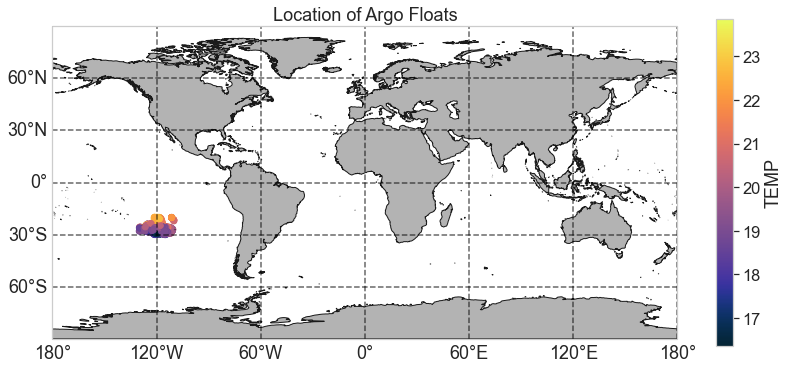

In [12]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
import seaborn as sns

sns.set(font_scale=1.5)  
sns.set_style("whitegrid")

plt.figure(figsize=(14,6))
# Projections
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()

# Plot
selected_vars.plot.scatter(x='LONGITUDE', y='LATITUDE', hue='TEMP', cmap = cmo.thermal, 
                         transform = ccrs.PlateCarree())
# Coastlines
coast_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='k', facecolor='0.7')
ax.add_feature(coast_50m)

# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, #x_inline=False, y_inline=False,
                  linewidth=1.5, color='black', alpha=0.6, linestyle='--')
gl.right_labels = False
gl.top_labels = False

plt.title('Location of Argo Floats')
plt.show()

In [14]:
# can also import directly indiviual floats

In [16]:
import argopy
import numpy as np
with argopy.set_options(src='erddap'):
    ds = ArgoDataFetcher().float([5904467]).to_xarray()
    ds_profiles = ds.argo.point2profile()
    ds_argo_4467 = ds_profiles.argo.interp_std_levels(np.arange(0,250,1))

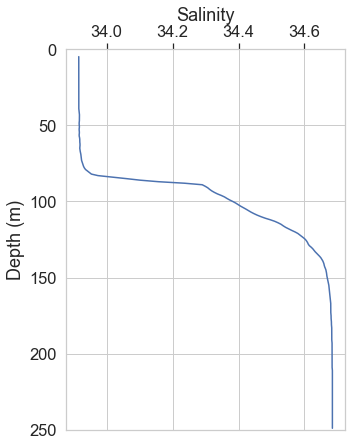

In [32]:
plt.figure(figsize=[5,7])
plt.plot(ds_argo_4467.PSAL[10],ds_argo_4467.PRES[10])   # select one profile
plt.ylim(250,0)
plt.ylabel('Depth (m)')
plt.xlabel('Salinity')
ax=plt.gca()
ax.xaxis.set_ticks_position('top') # the rest is the same
ax.xaxis.set_label_position('top')

## Glider data

In [1]:
from erddapy import ERDDAP


e = ERDDAP(
  server='https://gliders.ioos.us/erddap',
  protocol='tabledap',
)

e.response = 'csv'
e.dataset_id = 'whoi_406-20160902T1700'
e.constraints = {
    'time>=': '2016-07-10T00:00:00Z',
    'time<=': '2017-02-10T00:00:00Z',
    'latitude>=': 38.0,
    'latitude<=': 41.0,
    'longitude>=': -72.0,
    'longitude<=': -69.0,
}
e.variables = [
    'depth',
    'latitude',
    'longitude',
    'salinity',
    'temperature',
    'time',
]

df = e.to_pandas()

In [30]:
df.head()

,depth (m),latitude (degrees_north),longitude (degrees_east),salinity (1),temperature (Celsius),time (UTC)
0,5.35,40.990881,-71.12439,32.245422,20.6620,2016-09-03T20:15:46Z
1,6.09,40.990881,-71.12439,32.223183,20.6512,2016-09-03T20:15:46Z
2,6.72,40.990881,-71.12439,32.237950,20.6047,2016-09-03T20:15:46Z
3,7.37,40.990881,-71.12439,32.235470,20.5843,2016-09-03T20:15:46Z
4,8.43,40.990881,-71.12439,32.224503,20.5691,2016-09-03T20:15:46Z


In [81]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import seaborn as sns
import cmocean.cm as cmo

sns.set(font_scale=1.5)  
sns.set_style("whitegrid")

def plot_glider_traj(variable):
    
    '''This function makes a map and plots a scatter of the glider trajectory
    colored by selected variable'''
    fig, ax = plt.subplots(
        figsize=(9, 9), subplot_kw={"projection": ccrs.PlateCarree()}
    )

    cs=ax.scatter(df["latitude (degrees_north)"],
               df["longitude (degrees_east)"],
              s=20,
              c=df[variable],
              cmap=cmo.haline
              )
    cbar=plt.colorbar(cs)
    cbar.set_label('{}'.format(variable))
    ax.coastlines("10m")

    gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=2, color='Grey',linestyle='--',alpha=0.1,
                 draw_labels=True)
    #g1.set_xlabels('top')
    gl.xlabels_top = False
    gl.ylabels_right=False
    gl.xlines = True

    

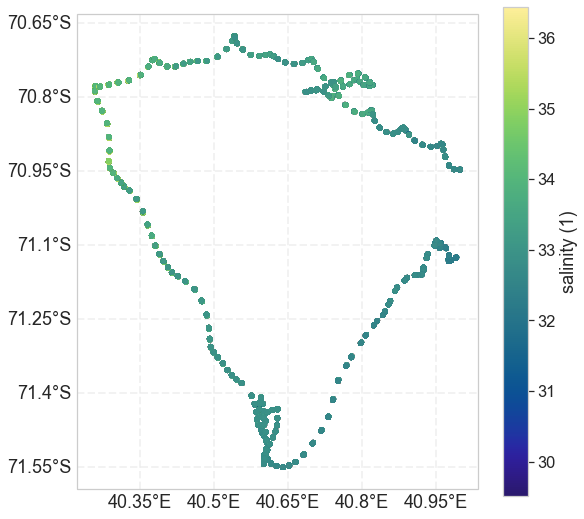

In [82]:
plot_glider_traj("salinity (1)")

In [58]:
# Now plot a transect

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib
#import seaborn as sns
import cmocean.cm as cmo
import numpy as np
matplotlib.rc_file_defaults()

#sns.set(font_scale=1.5)  
#sns.set_style("whitegrid")

def plot_glider_transect(variable):
    
    '''This function makes a section of a glider transect
    colored by selected variable'''
    fig, ax = plt.subplots(
        figsize=(12, 5)
    )
    
    #xx,yy=np.meshgrid(df["time (UTC)"],df["depth (m)"])    
    cs=ax.scatter(df["time (UTC)"],
               df["depth (m)"],
              s=10,
              c=df[variable],
              cmap=cmo.thermal
              )

    cbar=plt.colorbar(cs)
    cbar.set_label('{}'.format(variable))
       
    import matplotlib.ticker as plticker
    # toggle this - other resources 
    loc = plticker.MultipleLocator(base=150.0) # this locator puts ticks at regular intervals
    ax.xaxis.set_major_locator(loc)
    
    ax.set_ylim(125,0)
    ax.set_ylabel('Depth (m)')

Most date xticks can be formatted following this tutorial   
https://matplotlib.org/3.1.1/api/dates_api.html

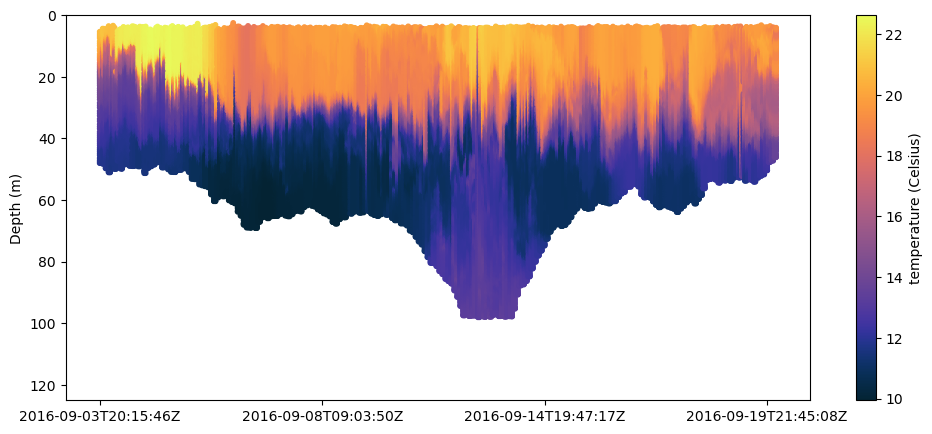

In [59]:
plot_glider_transect("temperature (Celsius)")

## Saildrone data

In [2]:
from erddapy import ERDDAP

server = "https://ferret.pmel.noaa.gov/pmel/erddap"
e = ERDDAP(server=server, protocol="tabledap")

e.dataset_id = "saildrone_arctic_data"

Link to other available datasets at this server - look for saildrone  
https://ferret.pmel.noaa.gov/pmel/erddap/info/index.html?page=1&itemsPerPage=1000

In [13]:
# select variables

e.variables = [
    "trajectory",
    "latitude",
    "longitude",
    "TEMP_CTD_MEAN",
]

In [15]:
# have a look

df = e.to_pandas()
df.head()

,trajectory,latitude (degrees_north),longitude (degrees_east),TEMP_CTD_MEAN (degrees_c)
0,1001.0,53.888685,-166.564928,10.380
1,1001.0,53.889318,-166.565082,10.452
2,1001.0,53.889862,-166.565338,10.228
3,1001.0,53.890387,-166.565632,10.326
4,1001.0,53.890931,-166.565939,10.105


In [16]:
set(df["trajectory"])

{1001.0, 1002.0, 1003.0}

In [17]:

import cartopy.crs as ccrs
import matplotlib.pyplot as plt


def plot_saildrone():
    
    '''This function makes a map and plots a scatter of the saildrone trajectory
    colored by mean surface temperature'''
    fig, ax = plt.subplots(
        figsize=(9, 9), subplot_kw={"projection": ccrs.PlateCarree()}
    )

    for traj, data in df.groupby("trajectory"):
        ax.scatter(
            data["longitude (degrees_east)"],
            data["latitude (degrees_north)"],
            s=20,
            c=data["TEMP_CTD_MEAN (degrees_c)"],
        )
    ax.coastlines("10m")



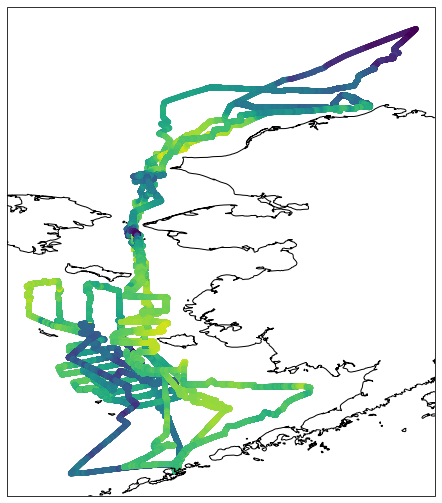

In [18]:
plot_saildrone()